In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold
import lightgbm as lgb
import itertools
from sklearn.metrics import roc_auc_score
import gc
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Dataset Loading and Merging

In [3]:
train_trains = pd.read_csv('../input/train_transaction.csv', index_col = 'TransactionID')
train_id = pd.read_csv('../input/train_identity.csv', index_col = 'TransactionID')
test_trains = pd.read_csv('../input/test_transaction.csv', index_col = 'TransactionID')
test_id = pd.read_csv('../input/test_identity.csv', index_col = 'TransactionID')

In [4]:
train_trains = reduce_mem_usage(train_trains)
train_id = reduce_mem_usage(train_id)
test_trains = reduce_mem_usage(test_trains)
test_id = reduce_mem_usage(test_id)

Memory usage of dataframe is 1775.15 MB --> 544.60 MB (Decreased by 69.3%)
Memory usage of dataframe is 45.12 MB --> 26.41 MB (Decreased by 41.5%)
Memory usage of dataframe is 1519.24 MB --> 474.52 MB (Decreased by 68.8%)
Memory usage of dataframe is 44.39 MB --> 25.98 MB (Decreased by 41.5%)


In [5]:
train = pd.merge(train_trains, train_id, on ='TransactionID', how = 'left')
test = pd.merge(test_trains, test_id, on = 'TransactionID', how = 'left')
train = train.reset_index()
test = test.reset_index()
print(train.shape)
print(test.shape)

(590540, 434)
(506691, 433)


In [6]:
del train_id, train_trains, test_id, test_trains
gc.collect()

134

In [7]:
train['isFraud'].value_counts(normalize = True)*100

0    96.500999
1     3.499001
Name: isFraud, dtype: float64

There is an imbalanced class problem

In [8]:
print('THERE ARE {0} MISSING VALUES IN TRAIN'.format(train.isnull().any().sum()))

THERE ARE 414 MISSING VALUES IN TRAIN


## Visualizations

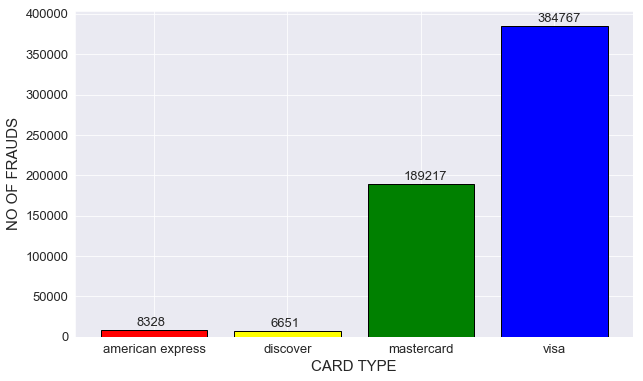

In [9]:
card_fraud = train[['isFraud', 'card4']].groupby(by = 'card4').count()
card_fraud = card_fraud.reset_index()
plt.figure(figsize = (10,6))
axes = plt.bar(x = card_fraud['card4'], height = card_fraud['isFraud'], color = ['red', 'yellow', 'green', 'blue'], edgecolor = 'Black')
plt.tick_params(labelsize = 13)
plt.xlabel('CARD TYPE', fontdict = {'fontsize':15})
plt.ylabel('NO OF FRAUDS', fontdict = {'fontsize':15})
for ax in axes.patches:
    plt.text(ax.get_x() + 0.27, ax.get_height() + 5000, str(round(ax.get_height(), 2)), fontdict= {'fontsize':13})
plt.show()

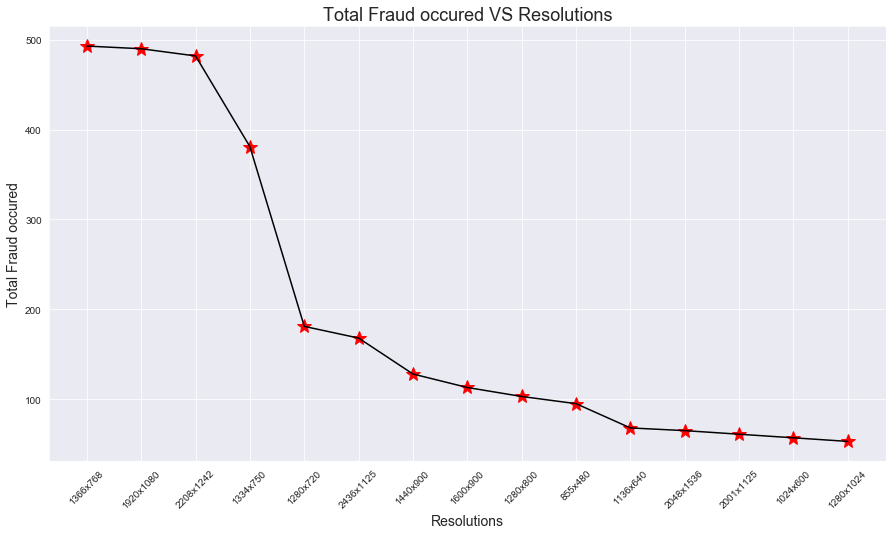

In [10]:
res_fraud = train[['isFraud', 'id_33']].groupby(by = 'id_33').sum().reset_index()
res_fraud = res_fraud.sort_values(by = 'isFraud', ascending = False)
res_fraud = res_fraud[:15][:]
plt.figure(figsize = (15,8))
plt.plot(res_fraud['id_33'], res_fraud['isFraud'],'*', color = 'red', markersize = 15)
plt.plot(res_fraud['id_33'], res_fraud['isFraud'], color = 'black') 
plt.xticks(rotation = 45)
plt.xlabel('Resolutions', fontdict = {'fontsize':14})
plt.ylabel('Total Fraud occured', fontdict = {'fontsize':14})
plt.title('Total Fraud occured VS Resolutions', fontdict = {'fontsize':18})
plt.show()

In [13]:
def label_collector(string):
    label = string.split('.')[0]
    return label

temp = train['P_emaildomain'].astype(str)
train['label_encode'] = temp.apply(label_collector)

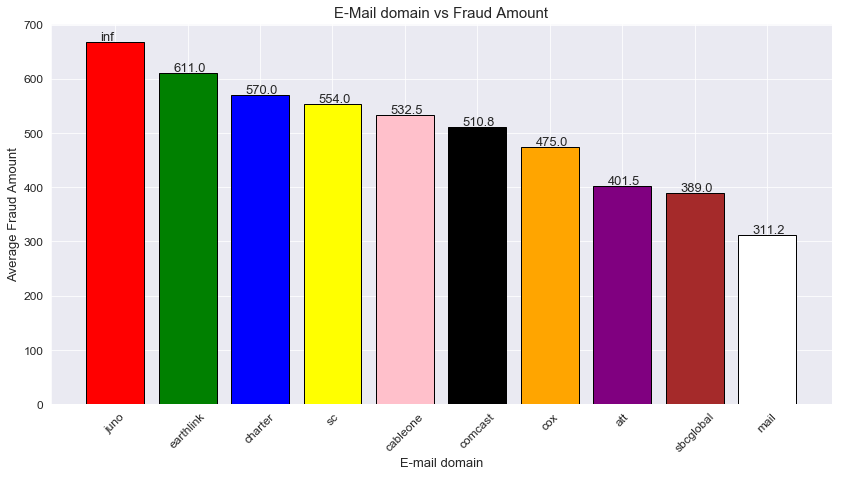

In [14]:
card_cost = train[['label_encode', 'TransactionAmt','isFraud']][train['isFraud']==1].groupby(by = 'label_encode').mean().reset_index()
card_cost = card_cost.sort_values(by = 'TransactionAmt', ascending = False)
plt.figure(figsize = (14,7))
plt.xticks(rotation = 45)
plt.xlabel('E-mail domain', fontdict = {'fontsize':13})
plt.ylabel('Average Fraud Amount', fontdict = {'fontsize':13})
plt.tick_params(labelsize = 12)
axes = plt.bar(x = card_cost['label_encode'].iloc[0:10], height = card_cost['TransactionAmt'].iloc[0:10], color = ['red','green', 'blue', 'yellow', 'pink', 'black', 'orange','purple', 'brown', 'white'], edgecolor = 'black')
for ax in axes.patches:
    plt.text(ax.get_x() + 0.2, ax.get_height() + 3, str(round(ax.get_height(), 2)), fontdict= {'fontsize':13})
plt.title('E-Mail domain vs Fraud Amount', fontdict = {'fontsize':15})
plt.show()
train = train.drop('label_encode', axis=1)

## Handling Missing Values and Encoding Necessary Columns

In [15]:
cols_drop_train = [cols for cols in train.columns if train[cols].isnull().sum()/ train.shape[0] > 0.9]
cols_drop_test = [cols for cols in test.columns if test[cols].isnull().sum()/ test.shape[0]> 0.9]
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
drop_cols = list(set(cols_drop_train + cols_drop_test + big_top_value_cols + big_top_value_cols_test))
drop_cols.remove('isFraud')

print("Going to drop the following columns")
print(drop_cols)

Going to drop the following columns
['V111', 'V113', 'D7', 'C3', 'V281', 'V299', 'V133', 'id_08', 'V318', 'V300', 'V28', 'V114', 'V104', 'V27', 'V121', 'V295', 'V103', 'V108', 'V135', 'V319', 'V134', 'V297', 'V321', 'V106', 'V286', 'V320', 'V116', 'id_21', 'V118', 'V55', 'V101', 'V284', 'V305', 'V316', 'id_22', 'V311', 'id_24', 'V23', 'V136', 'V102', 'V107', 'dist2', 'V66', 'V68', 'V109', 'V137', 'V298', 'V309', 'V24', 'V123', 'V124', 'V122', 'V119', 'id_07', 'V110', 'V129', 'V65', 'V26', 'V105', 'V290', 'V125', 'V77', 'V88', 'V25', 'V98', 'V293', 'V296', 'V132', 'V67', 'V117', 'V120', 'id_26', 'V112', 'id_27', 'V14', 'V115', 'id_23', 'V86', 'id_25', 'id_18', 'V89', 'V301']


In [17]:
train.drop(drop_cols, axis = 1, inplace = True)
test.drop(drop_cols, axis = 1, inplace = True)

del cols_drop_test, cols_drop_train, big_top_value_cols, big_top_value_cols_test, drop_cols

In [18]:
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

Should consider removing P/R_emaildomain since that is redundant

In [16]:
print("String columns")
print([cols for cols in train.columns if train[cols].dtype == 'O'])

String columns
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [41]:
def labelencode(train,test):
    for col in train.drop(['TransactionID','isFraud','TransactionDT'],axis = 1).columns:
        if train[col].dtype == 'O' or test[col].dtype == 'O':
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))
    return train,test

In [42]:
train, test = labelencode(train, test)

In [43]:
y_test = train['isFraud']

In [44]:
cols_drops = ['TransactionID','isFraud','TransactionDT']
train = train.drop(cols_drops, axis = 1)

In [46]:
train.columns

Index(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'addr2',
       ...
       'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'P_emaildomain_1',
       'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1',
       'R_emaildomain_2', 'R_emaildomain_3'],
      dtype='object', length=355)

In [47]:
# TODO more date time engineering
test = test.drop(['TransactionID','TransactionDT'], axis = 1)

In [48]:
train = train.fillna(-999)
test = test.fillna(-999)

In [49]:
## Modelling the Dataset
train_m, val_m_train, val1, val2 = train_test_split(train,y_test, test_size = 0.3, random_state = 10, stratify = y_test)
train_m_index = train_m.index
val_m_index = val_m_train.index
val1_index = val1.index
val2_index = val2.index

In [50]:
val_m_train.shape

(177162, 355)

In [19]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_37,id_38,DeviceType,DeviceInfo,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,gmail,com,None,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,outlook,com,None,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,yahoo,com,None,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,gmail,com,None,NaN,NaN,NaN


In [22]:
# add time features
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [23]:
train[['TransactionDT', '_Weekdays', '_Hours', '_Days']]

,TransactionDT,_Weekdays,_Hours,_Days
0,86400,5,0,2
1,86401,5,0,2
2,86469,5,0,2
3,86499,5,0,2
4,86506,5,0,2
5,86510,5,0,2
6,86522,5,0,2
7,86529,5,0,2
8,86535,5,0,2
9,86536,5,0,2


## Bayesian Optimization for Hyperparameter Optimization

In [52]:
def objective(num_leaves,min_child_weight,feature_fraction,bagging_fraction,
              max_depth,learning_rate,reg_alpha,reg_lambda,min_data_in_leaf):
    global train_m
    global val_m
    global y_test
    global train_m_index
    global val_m_index
    global val1,val2, val1_index, val2_index
    num_leaves = int(num_leaves)
    max_depth = int(max_depth)
    min_data_in_leaf = int(min_data_in_leaf)
    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    params = {'num_leaves': num_leaves,
          'min_child_weight': min_child_weight,
          'feature_fraction': feature_fraction,
          'bagging_fraction': bagging_fraction,
          'min_data_in_leaf': min_data_in_leaf,
          'objective': 'binary',
          'max_depth': max_depth,
          'learning_rate': learning_rate,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': reg_alpha,
          'reg_lambda': reg_lambda,
          'random_state':42,
         }
    oof = np.zeros(len(train_m))
    early_stopping_rounds = 50
    xgtrain = lgb.Dataset(train_m, label=val1[val1_index])
    xgvalid = lgb.Dataset(val_m_train, label=val2[val2_index])
    num_boost_round = 200
    model_lgb = lgb.train(params, xgtrain , valid_sets = [xgtrain, xgvalid], num_boost_round = num_boost_round,
                            early_stopping_rounds = early_stopping_rounds, verbose_eval = 0)
    score  = roc_auc_score(val2, model_lgb.predict(val_m_train))
    return score

In [53]:
bound_lgb = {'num_leaves': (70,600),
              'min_child_weight': (0.001, 0.07),
              'feature_fraction': (0.1,0.9),
              'bagging_fraction': (0.1,0.9),
              'max_depth': (-1,50),
              'learning_rate': (0.2,0.9),
              'reg_alpha': (0.3,0.9),
              'reg_lambda': (0.3,0.9),
              'min_data_in_leaf':(50,300)
         }

In [54]:
LGB_BO = BayesianOptimization(objective, bound_lgb, random_state=42)

In [55]:
LGB_BO.space.keys

['bagging_fraction',
 'feature_fraction',
 'learning_rate',
 'max_depth',
 'min_child_weight',
 'min_data_in_leaf',
 'num_leaves',
 'reg_alpha',
 'reg_lambda']

In [ ]:
init_points = 10
n_iter = 15
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter,acq='ucb', xi=0.0, alpha=1e-5)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
